KoNLPy를 사용한 영화 리뷰 분석 (한국어)

- konlpy는 여러 언어로 만들어진 형태소 분석기이다. 
- 네이버 영화 리뷰 데이터셋 이용
  ( 첫줄은 제목, 그 다음 데이터 기록 )
 

In [1]:
#데이터는 탭으로 구분되어 있다. 
import pandas as pd

df_train = pd.read_csv('ratings_train.txt', delimiter = '\t', keep_default_na = False)

df_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
#여기서 document열과 label열을 이용 0이면 부정 1이면 긍정적
#데이터 프레임을 Numpy 배열로 변환
import numpy as np

text_train, y_train = df_train['document'].values, df_train['label'].values

In [3]:
df_test = pd.read_csv('ratings_test.txt', delimiter ='\t', keep_default_na = False)

text_test = df_test['document'].values
y_test = df_test['label'].values

In [4]:
#비율 확인
from collections import Counter

len(text_train), Counter(y_train)

(150000, Counter({0: 75173, 1: 74827}))

In [5]:
len(text_test), Counter(y_test)

(50000, Counter({1: 25173, 0: 24827}))

- 데이터 비율은 비슷하다. 

In [16]:
#konlpy okt객체 생성
from konlpy.tag import Okt
okt_tag = Okt()

In [10]:
#TfidFVectorizer의 tokenizer 매개변수 주입할 함수 생성
#okt의 형태소 분석 메서드인 morphs 받은 문자열의 리스트를 그대로 반환
def okt_tokenizer(text):
    return okt_tag.morphs(text)

In [11]:
#Tfidf의 min_df와 ngram_range, LogisticRegression의 C에 대한 그리드서치진행
#훈련 데이터 1000개만 적용

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

okt_param_grid = {'tfidfvectorizer__min_df':[3,5,7],
                 'tfidfvectorizer__ngram_range':[(1,1),(1,2),(1,3)],
                 'logisticregression__C':[0.1,1,10]}
okt_pipe = make_pipeline(TfidfVectorizer(tokenizer = okt_tokenizer),
                        LogisticRegression(solver='liblinear'))

okt_grid = GridSearchCV(okt_pipe, okt_param_grid, cv=3)

#그리드 서치 수행
okt_grid.fit(text_train[0:1000], y_train[0:1000])
print('최상 교차 검증 점수 :', okt_grid.best_score_)
print('최적 교차 검증 매개변수 :', okt_grid.best_params_)

최상 교차 검증 점수 : 0.7039914165662667
최적 교차 검증 매개변수 : {'logisticregression__C': 1, 'tfidfvectorizer__min_df': 3, 'tfidfvectorizer__ngram_range': (1, 1)}


- 1000개의 데이터만 이용해도 70% 가까운 교차검증 점수 획득

In [20]:
#테스트 셋에 대한 점수 획득

X_test_okt = okt_grid.best_estimator_.named_steps['tfidfvectorizer'].transform(text_test)
score = okt_grid.best_estimator_.named_steps['logisticregression'].score(X_test_okt,y_test)

print('테스트 셋 점수 :', score)

테스트 셋 점수 : 0.70516


- 전체 훈련 데이터셋 이용하면 그리드 서치에 시간이 오래걸린다. 
- n_jobs의 매개변수를 조정하여 병렬로 처리 가능하다. 

In [ ]:
#Konlpy의 Mecab 태크 클래스가 있지만 윈도우에서는 지원이 되지 않아 예제만 작성

from konlpy.tag import Mecab
mecab = Mecab()

def mecab_tokenizer(text):
    return mecab.morphs(text)

In [ ]:
#Mecab의 그리드서치

mecab_param_grid = {'tfidfvecotrizer__min_df':[3,5,7],
                   'tfidfvectorizer__ngram_range':[(1,1),(1,2),(1,3)],
                   'logisticregression__C':[0.1,1,10,100]}
mecab_pipe = make_pipeline(TfidfVectorizer(tokenizer=mecab_tokenizer),
                          LogisticRegression(solver='liblinear'))
mecab_grid = GridSearchCV(mecab_pipe, mecab_param_grid, n_jobs = 1, cv = 3)

#그리드 서치 수행
mecab_grid.fit(text_train, y_train)
print('최상의 CV 점수 :',mecab_grid.best_score_)
print('최상의 CV parmas :', mecab_grid.best_params_)


In [ ]:
#Mecat 테스트 점수
X_test_mecab = mecab_grid.best_estimator_.named_steps['tfidfvectorizer'].transform(text_test)

score = mecab_grid.best_estimator_.named_steps['logisticregression'].score(X_test_mecab, y_test)
print('테스트 점수 :', score)

토픽 모델링과 문서 군집화 

- 텍스트 데이터에 자주 적용하는 특별한 기법으로 토픽 모델링이 있다. 
- 비지도 학습으로서 문서를 하나 또는 그 이상의 토픽으로 할당하는 작업을 통칭한다. 
- 한 문서가 하나의 토픽에 할당되면 문서를 군집시키는 문제가 된다. 
- 둘 이상의 토픽을 가지면 분해 방법과 관련이 있다. 
- 토픽 모델링을 언급할 때 잠재 디리클레 할당(LDA)라고 하는 특정 성부 분해 방법을 말한다.

    1) LDA
    - 함께 자주 나타나는 단어의 그룹(토픽)을 찾는 것이다. 
    - 각 문서에 토픽의 일부가 혼합되어 있다고 간주 
    - 우리가 일상에서 말하는 주제가 아닌 PCA나 NMF로 추출한 성분에 가깝다

In [21]:
from sklearn.datasets import load_files

reviews_train = load_files('aclImdb_v1.tar/aclImdb/train/')

#텍스트, 레이블 포함한 Brunch 오브젝트 반환

text_train, y_train = reviews_train.data, reviews_train.target

print('text_train 타입 : ', type(text_train))
print('text_train 길이 :', len(text_train))
print('text_train[6]:\n', text_train[6])

text_train 타입 :  <class 'list'>
text_train 길이 : 75000
text_train[6]:
 b'Gloomy Sunday - Ein Lied von Liebe und Tod directed by Rolf Sch\xc3\xbcbel in 1999 is a romantic, absorbing, beautiful, and heartbreaking movie. It started like Jules and Jim; it ended as one of Agatha Christie\'s books, and in between it said something about love, friendship, devotion, jealousy, war, Holocaust, dignity, and betrayal, and it did better than The Black Book which is much more popular. It is not perfect, and it made me, a cynic, wonder in the end on the complexity of the relationships and sensational revelations, and who is who to whom but the movie simply overwhelmed me. Perfect or not, it is unforgettable. All four actors as the parts of the tragic not even a triangle but a rectangle were terrific. I do believe that three men could fell deeply for one girl as beautiful and dignified as Ilona in a star-making performance by young Hungarian actress Erica Marozs\xc3\xa1n and who would not? The titular 

In [23]:
#실제 LDA 작동확인을 위해 15%의 문서에 나타난 단어를 삭제한후 가장 많이 등장하는 단어 10,000개에 대한 BOW 모델 생성
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features =10000, max_df = .15)
X = vect.fit_transform(text_train)

- 10개의 토픽으로 토픽 모델 학습
- NMF의 성분과 비슷하게 토픽은 순서를 가지지 않으며, 토픽의 수를 바꾸면 모든 토픽이 바뀌게 된다. 
- 기본 학습 방법('online') 대신 조금 느리지만 성능이 더 나은 'batch'방법을 사용하고 모델 성능을 위해 max_iter값 증가

(NMF와 LDA는 유사한 문제를 풀 수 있어 토픽 추출에 NMF 이용 가능 )
(LDA는 온라인 변분 베이즈 알고리즘을 이용하여 max_iter 매개변수의 기본값은 10이다)

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, learning_method= 'batch', max_iter = 25, random_state = 0)

#모델 생성과 변환 한번에 시도
#변환시간이 좀 걸린다. 
document_topics = lda.fit_transform(X)

In [27]:
#LDA는 각 토픽마다 중요도를 저장한 components_속성이 있따. 크기는(n_topics, n_words)다
print('lda.components_.shape', lda.components_.shape)

lda.components_.shape (10, 10000)


In [28]:
#각 토픽이 의미하는 것이 무엇인지 이해하기 위해 토픽에서 가장 중요 단어 확인 - print_topics
import numpy as np

#토픽마다(components_의 행)을 오름차순으로 정렬
#내림차순이 되도록 [:, ::-1]를 이용해 행의 정렬을 반대로 바꾼다. 
sorting = np.argsort(lda.components_, axis = 1)[:,::-1]

#Countervectorizer 객체에서 특성 이름 구한다. 
feature_names = np.array(vect.get_feature_names())

#10개 토픽 출력
import mglearn

mglearn.tools.print_topics(topics=range(10), feature_names = feature_names, sorting=sorting, topics_per_chunk = 5, n_words = 10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
action        guy           war           show          didn          
game          re            world         series        thought       
effects       around        american      tv            actors        
special       nothing       us            episode       nothing       
fight         sex           our           years         am            
fi            looks         documentary   old           10            
sci           pretty        history       now           worst         
10            look          real          kids          going         
star          worst         black         dvd           got           
alien         stupid        america       shows         actually      


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
dire

c:\python\python38\lib\site-packages\sklearn\externals\six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "
c:\python\python38\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [29]:
#100개의 토픽으로 새로운 모델 학습 - 많은 토픽 이용하면 분석은 어려워지지만 데이터의 특이한 부분을 잘 잡을 수 있다. 

lda100 = LatentDirichletAllocation(n_components = 100, learning_method='batch', max_iter =25, random_state = 0)
document_topics100 = lda100.fit_transform(X)

In [30]:
#100의 토픽을 나열하면 길어 대표 토픽 확인

topics = np.array([7,16, 24,25,28,36,37,41,45,51,53,54,63,89,97])

sorting = np.argsort(lda100.components_, axis = 1)[:,::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names, sorting = sorting, topics_per_chunk=5, n_words = 20)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
allen         dvd           virus         island        town          
woody         video         cannibal      plane         western       
rose          budget        franco        ship          west          
julia         low           jungle        captain       small         
chaplin       store         freaks        crash         sheriff       
roberts       copy          flesh         flight        mexican       
real          find          eating        treasure      westerns      
woman         production    circus        flying        mexico        
restaurant    cover         disease       air           gold          
plays         buy           tribe         harvey        local         
bar           rent          apocalypse    lost          wild          
wife          bought        italian       airport       gun           
manhat

- 추출한 토픽이 구체적으로 보이지만, 해석하기는 어렵다. 
- 토픽을 이용해 추론을 더 잘하려면 토픽에 할당된 문서를 보고 가장 높은 순위의 단어를 확인해야 하낟. 

In [31]:
#음악적 토픽 45를 가중치로 정렬
music = np.argsort(document_topics100[:, 45])[::-1]

#이 토픽이 ㅁ비중이 큰 문서 다섯개 출력
for i in music[:10]:
    #첫 두문장 출력
    print(b".".join(text_train[i].split(b".")[:2])+b",\n")

b'A superior work that takes itself seriously, but avoids the tiresome moralizing so often accompnaying American films of the same subject matter. See it if you can,\n'
b"Che is a good film for chronicling the events leading to the Cuban Revolution and certainly has a mystic potency surrounding Che and his political ideals. However there is no emotional core or compassionate deliverance to make this anything more than interesting, and is a friendly inspection of Che's mindset rather than anything inspiring,\n"
b"If you were to cut an hour of this movie you might have something a little bit entertaining, although even then I don't think you'd have anything memorable. But at its full, seemingly endless length this movie just meanders on endlessly,\n"
b"It's this sort of movie that you try and imitate. By attempting to realise something,\n"
b'This unpleasant film has little to recommend it. Dolph Lundgren gives a performance that is better than either this script or his other action films

- 토픽을 조사하는 다른 방법은 각 토픽의 가중치가 얼마인지 모든 리뷰에 걸쳐 document_topics의 값을

  합해서 보는 것이다. 
  
- 각 토픽을 대표하는 두 단어로 토픽 이름을 붙였다.

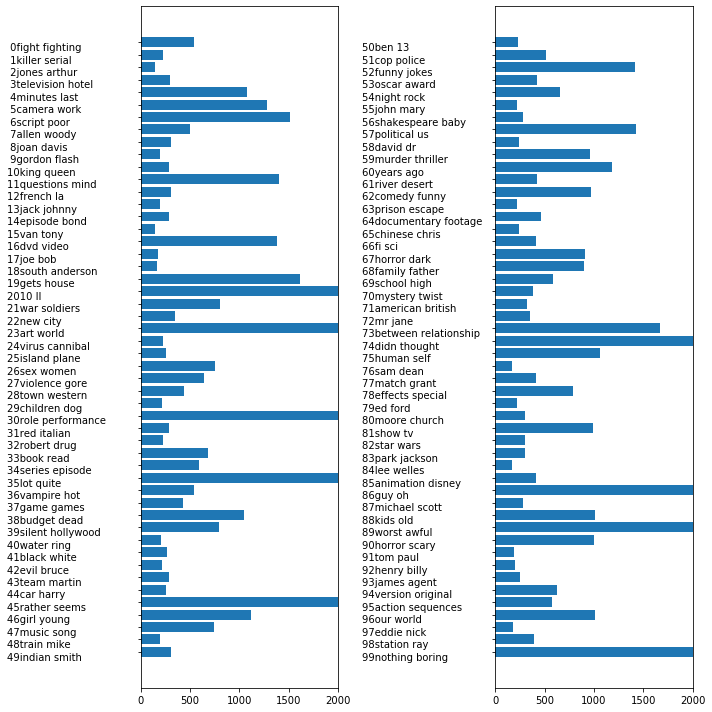

In [34]:
#학습된 토픽의 가중치
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,10))
topic_names = ["{:>2}".format(i) + " ".join(words)
              for i, words in enumerate(feature_names[sorting[:,:2]])]

#열이 두개인 막대 그래프

for col in [0, 1] :
    start = col*50
    end = (col+1)*50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis = 0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha = 'left', va ='top')
    ax[col].invert_yaxis()
    ax[col].set_xlim(0,2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

- LDA와 같은 토픽 모델은 레이블이 없거나 레이블이 있더라도 큰 규모의 텍스트 말뭉치를 해석하는데 좋은 방법이다. 
- LDA는 확률적 알고리즘이기 때문에 random_state 매개변수를 바꾸면 결과가 많이 달라진다. 
- 토픽으로 구별하는게 도움이 되더라도 비지도 학습에서 내린 결론은 각 토픽에 해당하는 문서를 직접보고
  
  검증하는 것이 좋다. 
- LDA.transform 메서드에서 만든 토픽이 지도 학습을 위한 압축된 표현으로 사용될 수 있다. (훈련 샘플 적을 때 유용 )